In [7]:
import pickle 
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import models.custom.detector as g
from libs.dataset_utils import prepare_data_from_tfrecord
from libs.image_utils import (get_random_patch_list,
                              draw_bounding_box,
                              calc_iou_accuracy,
                              calc_iou_top_1_accuracy)
from libs.various_utils import load_from_pickle
from configs.project_config import project_path
from helpers import (evaluate,
                     visualize,
                     visualize_cam,
                     restore_preprocessed)

In [8]:
"""
Constant
"""
NUM_CLASS = 200
INPUT_SHAPE = (64, 64, 3)
MODEL_BASE_INPUT_SHAPE = (224, 224, 3)

tfrecord_train_dir = "{}/data/tiny-imagenet-200/tfrecord/train".format(project_path)
tfrecord_valid_dir = "{}/data/tiny-imagenet-200/tfrecord/valid".format(project_path)
tfrecord_test_dir = "{}/data/tiny-imagenet-200/tfrecord/test".format(project_path)

meta_path = "{}/data/tiny-imagenet-200/meta.pickle".format(project_path)
pretrained_ckpt_path = "{}/checkpoints/inception_v3/inception_v3.ckpt".format(project_path)

has_model_save_path = "{}/checkpoints/has_inception_v3/has_inception_v3".format(project_path)
has_pretrained_path = "{}/checkpoints/pretrained/has_inception_v3/has_inception_v3".format(project_path)

pickle_data_full_path = "{}/data/tiny-imagenet-200/pickle/tiny_imagenet.pickle".format(project_path)

# Build Model, Dataset Pipeline and Load Pretrained Inception Weights

In [9]:
# ==============================================================================
# model_base_name : { "InceptionV3", "InceptionV3", "alexnet_v2"}
# 각 모델마다 final endpoint를 변경할 수 있다. final endpoint 의 정보는 models/안에 모델별 폴더안의 python 파일에 들어있다.
model_base_name = "InceptionV3"
model = g.Detector(output_dim=NUM_CLASS,
                   input_shape=INPUT_SHAPE,
                   model_base_input_shape=MODEL_BASE_INPUT_SHAPE,
                   model_base_name=model_base_name,
                   model_base_final_endpoint='Mixed_7c',
                   model_name="hide_and_seek")

X_preprocessed shape: [None, 224, 224, 3]
last_conv shape : [None, 5, 5, 1024]
gap shape :[None, 1, 1, 1024]
h shape :[None, 1, 1, 1024]
logits_before shape :[None, 1, 1, 200]
logits shape :[None, 200]
W shape :[1, 1, 1024, 200]
class_weight_by_row shape : [200, 1024]
batch_class_weight shape : [None, 1024, 1]
last_conv_flatten_w_h shape : [None, 4096, 1024]
clf_var_to_optimize_list
[<tf.Variable 'clf/conv/weights:0' shape=(3, 3, 2048, 1024) dtype=float32_ref>,
 <tf.Variable 'clf/conv/BatchNorm/beta:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'clf/conv/BatchNorm/moving_mean:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'clf/conv/BatchNorm/moving_variance:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'clf/logits/weights:0' shape=(1, 1, 1024, 200) dtype=float32_ref>,
 <tf.Variable 'clf/logits/biases:0' shape=(200,) dtype=float32_ref>]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
I'm dead
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [10]:
# ==============================================================================
"""
Load Model
"""
try :
    d = load_from_pickle(pickle_data_full_path)
    (X_train, P_train, Y_train, Y_train_one_hot) = (d['X_train'], d['P_train'], d['Y_train'] ,d['Y_train_one_hot'])
    (X_valid, P_valid, Y_valid, Y_valid_one_hot) = (d['X_valid'], d['P_valid'], d['Y_valid'] ,d['Y_valid_one_hot'])
    (X_test, P_test, Y_test, Y_test_one_hot) = (d['X_test'], d['P_test'], d['Y_test'] ,d['Y_test_one_hot'])
    (idx_word_dict, word_idx_dict) = (d['idx_word_dict'], d['word_idx_dict'])
    (idx_nid_dict, nid_idx_dict) = (d['idx_nid_dict'], d['nid_idx_dict'])
except Exception as e: 
    print("maybe there is no pickle data: {}".format(e))

In [11]:
# ==============================================================================
with model.g.as_default():
    """
    Read Data
    """
    d = prepare_data_from_tfrecord(
        tfrecord_train_dir=tfrecord_train_dir,
        tfrecord_valid_dir=tfrecord_valid_dir,
        tfrecord_test_dir=tfrecord_test_dir,
        batch_size=200,
        shuffle_buffer_size=1000)
    (X, Y,
     init_dataset_train,
     init_dataset_train_has,
     init_dataset_valid) = (d['X'], d['Y'],
                            d['init_dataset_train'],
                            d['init_dataset_train_has'],
                            d['init_dataset_valid'])

    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    model.meta.update(meta)

    """
    Initialize with pretrained weights
    """
#     variables_to_restore = tf.contrib.framework.get_variables_to_restore(
#         include=[model_base_name])
#     init_pretrain_fn = tf.contrib.framework.assign_from_checkpoint_fn(
#         pretrained_ckpt_path, variables_to_restore)

#     init_pretrain_fn(model.sess)

# Make Sample Data

In [12]:
model.sess.run(init_dataset_train)
X_sample_preprocessed, Y_sample_one_hot = model.sess.run([X, Y])
X_sample =restore_preprocessed(X_sample_preprocessed)
Y_sample = np.argmax(Y_sample_one_hot, axis=1)

# HaS input Test

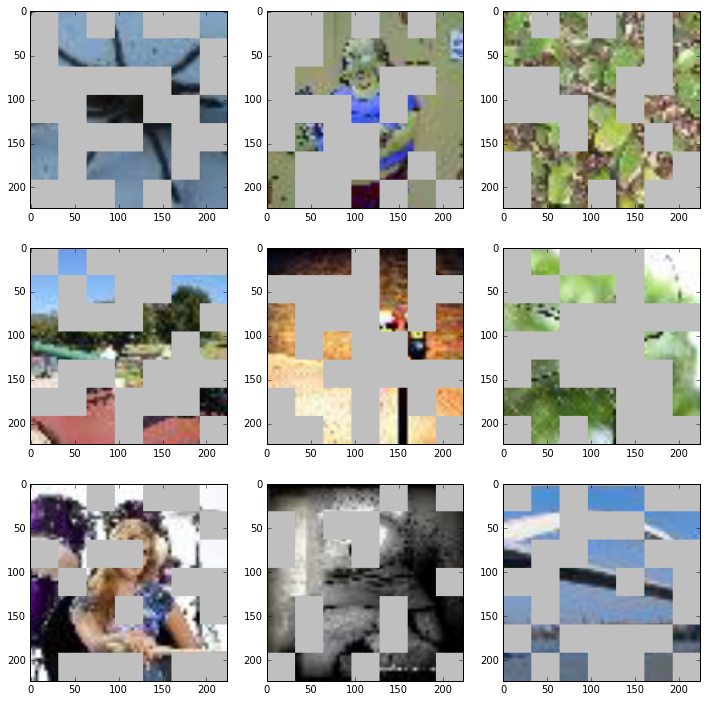

In [13]:
model.sess.run(init_dataset_train_has)
X_sample = model.sess.run(X)
X_sample_restored =(X_sample*0.5+0.5)*255
X_sample_restored = X_sample_restored.astype(np.uint8)
fig, axs = plt.subplots(3,3, figsize=(12,12))
for y in range(3):
    for x in range(3):
        sample = X_sample_restored[x+(y%3)*3]
        axs[y][x].imshow(X_sample_restored[x+(y%3)*3])

# Hide and Seek

In [16]:
# ==============================================================================

model.train_with_dataset_api(X=X,
                             Y=Y,
                             init_dataset_train=init_dataset_train,
                             init_dataset_valid=init_dataset_valid,
                             n_epoch=2,
                             learning_rate=0.001,
                             reg_lambda=0.,
                             dropout_keep_prob=0.8,
                             patience=10,
                             verbose_interval=1,
                             mode=g.MODE_TRAIN_ONLY_CLF,
                             save_dir_path=None)



  0%|          | 0/2 [00:00<?, ?it/s]

******************************
Make directory with save_dir_path is failed
Maybe, there is directory already or error because of "[Errno 17] File exists: './tmp/20180903_235249_VKZ0Z9'"




epoch 0, batch 0 takes: 3.07 sec:   0%|          | 0/2 [00:03<?, ?it/s]

epoch 0, batch 1 takes: 1.12 sec:   0%|          | 0/2 [00:04<?, ?it/s]

epoch 0, batch 2 takes: 1.10 sec:   0%|          | 0/2 [00:05<?, ?it/s]

epoch 0, batch 3 takes: 1.12 sec:   0%|          | 0/2 [00:06<?, ?it/s]

epoch 0, batch 4 takes: 1.09 sec:   0%|          | 0/2 [00:07<?, ?it/s]

epoch 0, batch 5 takes: 1.12 sec:   0%|          | 0/2 [00:08<?, ?it/s]

epoch 0, batch 6 takes: 1.12 sec:   0%|          | 0/2 [00:09<?, ?it/s]

epoch 0, batch 7 takes: 1.15 sec:   0%|          | 0/2 [00:10<?, ?it/s]

epoch 0, batch 8 takes: 1.13 sec:   0%|          | 0/2 [00:12<?, ?it/s]

epoch 0, batch 9 takes: 1.14 sec:   0%|          | 0/2 [00:13<?, ?it/s]

epoch 0, batch 10 takes: 1.13 sec:   0%|          | 0/2 [00:14<?, ?it/s]

epoch 0, batch 11 takes: 1.16 sec:   0%|          | 0/2 [00:15<?, ?it/s]

epoch 0, batch 12 takes: 1.12 sec:   0%|          | 0/2 [00:16<?, ?it/s]

epoch 0, batch 13 takes: 1.11 sec:   0%|      

KeyboardInterrupt: 

In [18]:
model.train_with_dataset_api(X=X,
                             Y=Y,
                             init_dataset_train=init_dataset_train_has,
                             init_dataset_valid=init_dataset_valid,
                             n_epoch=1,
                             learning_rate=0.001,
                             reg_lambda=0.,
                             dropout_keep_prob=0.8,
                             patience=10,
                             verbose_interval=1,
                             mode=g.MODE_TRAIN_GLOBAL,
                             save_dir_path=None)




  0%|          | 0/1 [00:00<?, ?it/s]

******************************
Make directory with save_dir_path is failed
Maybe, there is directory already or error because of "[Errno 17] File exists: './tmp/20180903_235249_VKZ0Z9'"


ResourceExhaustedError: OOM when allocating tensor with shape[200,25,25,96]
	 [[Node: InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/Relu, InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/weights/read)]]

Caused by op 'InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/Conv2D', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-8459d75442e9>", line 10, in <module>
    model_name="hide_and_seek")
  File "/home/sungju/projects/sj/hide_and_seek/models/custom/detector.py", line 157, in __init__
  File "/home/sungju/projects/sj/hide_and_seek/models/custom/detector.py", line 208, in build_model
    with slim.arg_scope(model_arg_scope(weight_decay=reg_lambda)):
  File "/home/sungju/projects/sj/hide_and_seek/models/custom/detector.py", line 36, in build_inception_v3_base
  File "/home/sungju/projects/sj/hide_and_seek/models/inception/inception_v3.py", line 156, in inception_v3_base
    scope='Conv2d_0c_3x3')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1033, in convolution
    outputs = layer.apply(inputs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/convolutional.py", line 167, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[200,25,25,96]
	 [[Node: InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/Relu, InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/weights/read)]]


In [ ]:
model.save(has_model_save_path)

# Run Sample

In [ ]:
# ==============================================================================
num_sample = 100
X_sample =  X_train[:num_sample]
P_sample = P_train[:num_sample]
Y_sample_one_hot = Y_train_one_hot[:num_sample]
Y_sample = Y_train[:num_sample]

In [ ]:
(cam_list_sample,
bbox_list_sample,
gt_known_loc_accuracy_sample,
top_1_loc_accuracy_sample) = evaluate(model, X_sample, P_sample, Y_sample_one_hot, 'sample')

In [ ]:
visualize_cam(X_rmded.astype(np.uint8), Y_sample, cam_list_sample, idx_word_dict, n_show=3, start=0)

# Evaluation

In [ ]:
(cam_list_train,
bbox_list_train,
gt_known_loc_accuracy_train,
top_1_loc_accuracy_train) = evaluate(model, X_train, P_train, Y_train_one_hot, 'train')

In [ ]:
(cam_list_valid,
bbox_list_valid,
gt_known_loc_accuracy_valid,
top_1_loc_accuracy_valid) = evaluate(model, X_valid, P_valid, Y_valid_one_hot, 'valid')

In [ ]:
(cam_list_test,
bbox_list_test,
gt_known_loc_accuracy_test,
top_1_loc_accuracy_test) = evaluate(model, X_test, P_test, Y_test_one_hot, 'test')

# Visualization

In [ ]:
visualize(X_train, P_train, Y_train, cam_list_train, bbox_list_train, idx_word_dict,
          n_show=3, start=0)

In [ ]:
visualize(X_valid, P_valid, Y_valid, cam_list_valid, bbox_list_valid, idx_word_dict,
          n_show=3, start=0)

In [ ]:
visualize(X_test, P_test, Y_test, cam_list_test, bbox_list_test, idx_word_dict,
          n_show=3, start=0)